In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:

#this section defines geometry
# an array of left co ordinates of each mesh is genrated and corresponding sigma arrays containing cross secitons are also generated
#this is one of the oldest code that i wrote for MOC, so the geometry declaration is a bit clumsy.
#the problem is the popular reed's cell problem taken from https://doi.org/10.13182/NSE46-309
#the reference solution is taken from https://github.com/DrRyanMc/Benchmarks/blob/master/ReedsProblem.nb


sigma_t_material = np.array([50, 5, 0, 1, 1])
sigma_s_material = np.array([0, 0, 0, 0.9, 0.9])
nu_sigmaf_material = np.array([0.0, 0, 0, 0, 0])
source_material = np.array([50.0, 0, 0, 1, 0])


width_material = np.array([2, 1, 2,1,2]) # storing width for each region in MFP
cellsize_material = 0.01
mesh_divisions_per_region = width_material/cellsize_material

sigma_t=np.empty(0)
sigma_s = np.empty(0)
nu_sigmaf = np.empty(0)
h_i = np.empty(0)
s_i = np.empty(0)
region = 0
x = 0
x_i =np.zeros(0)
cells_from_0 = 0
for typ in range(5):

    

    x_region = np.arange(x+cellsize_material/2, x+width_material[typ], cellsize_material) #co ordinates of left endpoints each cell in fuel region
    x_i = np.append(x_i ,x_region )
    s_i = np.append(s_i,np.ones(len(x_region))*source_material[typ])

    sigma_t = np.append(sigma_t,np.ones(len(x_region))*sigma_t_material[typ])
    sigma_s = np.append(sigma_s,np.ones(len(x_region))*sigma_s_material[typ])
    nu_sigmaf = np.append(nu_sigmaf,np.ones(len(x_region))*nu_sigmaf_material[typ])
    h_i = np.append(h_i,np.ones(len(x_region))*cellsize_material)
    x=x+width_material[typ]



In [11]:

polar =3
azim = 32

#tabuchi_yamamoto quadrature set
sintheta_p = np.array([.166648, .537707, .932954])
theta_p = (np.arcsin(sintheta_p))
w_p = 2*(np.array([0.046233, 0.283619, 0.670148]))

mu_pplushalf = np.zeros(polar+1)

for i in range(polar+1):
    
    mu_pplushalf[i] = -1+sum(w_p[0:i])


#azimuthal angle 
w_b = 2*np.pi / azim
beta_b = np.arange(w_b/2,2*np.pi, w_b )

#exploiting symmetry
w_b = np.ones(azim)*w_b*2
azim = int(azim/2)



In [12]:
#transport sweep
def sweep_1d(q_i):
    I = len(x_i)
    alpha = 1 #vacuum at right
    psi_0 = 0 #no incident on left    
    #flux =  q_i/ sigma_t
    flux = np.zeros(I)
    del_psi = np.zeros((azim,polar))
    psi_boun = np.zeros((2,int(azim/2),polar))
    psi_avg = np.zeros((azim,polar))
    psi_in = np.zeros((azim,polar))
    #from right to left
    for i in reversed(range(I)):
        
        for p in range(polar):
            for b in range(int(azim/2),azim):
                length = abs(h_i[i]/(sintheta_p[p])/np.cos(beta_b[b]))
                if(sigma_t[i] ==0):
                    del_psi[b,p] = 0
                    psi_avg[b,p] = psi_in[b,p]
                else:
                    del_psi[b,p] = (psi_in[b,p] - q_i[i]/(4*np.pi*sigma_t[i]))*(1-np.exp(-sigma_t[i]*length))
                    psi_avg[b,p] = q_i[i]/(4*np.pi*sigma_t[i]) + del_psi[b,p]/(sigma_t[i]*length)
                flux[i] = flux[i] + w_b[b]*w_p[p]*psi_avg[b,p]
                #flux[i] = flux[i] + 1/(sigma_t[i]*length) * del_psi[b,p] *w_b[b]*w_p[p]
                psi_in[b,p] = psi_in[b,p] - del_psi[b,p]

        
           
    psi_boun[1] = psi_in[int(azim/2):azim] #psi left
    psi_in[0:int(azim/2), :] = alpha* np.flipud(psi_in[int(azim/2):azim,:])
    #psi_in[int(azim/2):azim, :] = 0
    #print(psi_in)
    
    
    
    #left to right
    for i in range(I):
        
        for p in range(int(polar)):
            for b in range(int(azim/2)):
                
                length = abs(h_i[i]/(sintheta_p[p])/np.cos(beta_b[b]))
                if(sigma_t[i] ==0):
                    del_psi[b,p] = 0
                    psi_avg[b,p] = psi_in[b,p]
                else:
                    del_psi[b,p] = (psi_in[b,p] - q_i[i]/(4*np.pi*sigma_t[i]))*(1-np.exp(-sigma_t[i]*length))
                    psi_avg[b,p] = q_i[i]/(4*np.pi*sigma_t[i]) + del_psi[b,p]/(sigma_t[i]*length)
                flux[i] = flux[i] + w_b[b]*w_p[p]*psi_avg[b,p]
                
                #flux[i] = flux[i] + 1/(sigma_t[i]*length) * del_psi[b,p] *w_b[b]*w_p[p] 
                psi_in[b,p] = psi_in[b,p] - del_psi[b,p]

    psi_boun[0] = psi_in[0:int(azim/2)] #right psi    

    return flux,psi_boun

In [13]:
I = len(x_i)
flux_new = np.zeros(I)
flux_old = np.zeros(I)

res_flux = np.inf

while (res_flux>10**-5):
    q_i = s_i + flux_old*sigma_s
    flux_new, psi_boun = sweep_1d(q_i)

    res_flux = max(abs((flux_new-flux_old)/flux_new))
    flux_old = flux_new




    

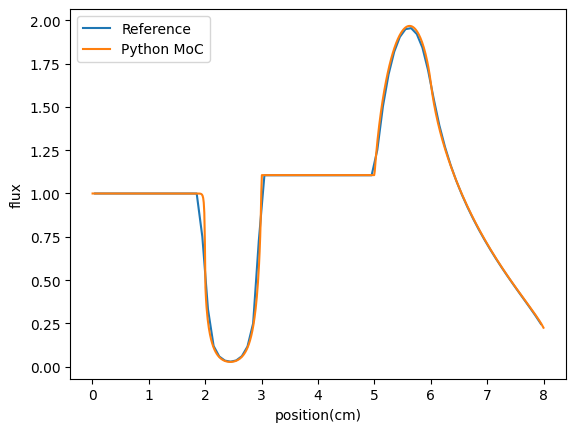

In [14]:
#solution from source
df = pd.read_csv('C:/Users/mdfah/Downloads/ReedSol.csv')

x_sol = df['x'].to_numpy()
x_sol = (x_sol[0:-1] + x_sol[1:len(x_sol)])/2
y_sol = df['y'].to_numpy()
y_sol = (y_sol[0:-1] + y_sol[1:len(y_sol)])/2
plt.plot(x_sol, y_sol ,label='Reference')
plt.plot(x_i,flux_new, label='Python MoC')

plt.xlabel("position(cm)")
plt.ylabel("flux")
plt.legend()
plt.show()